In [203]:
import numpy as np
import scipy.io as sio
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn.svm import SVC

In [209]:
def plotData(data):
    sns.set_style("white")
    sns.set_style('ticks')
    sns.set_context("talk")
    sns.lmplot(x='X1',y='X2',hue='Y',data=data,fit_reg=False)
    flatui = ["#e74c3c", "#34495e"]
    sns.set_palette(flatui)

In [205]:
def VisualizeBoundary(data,theta,c):
    plotData(data)
    sns.plt.title('C = %d'%c)
    x_plot=np.linspace(data['X1'].min()-0.5,data['X1'].max()+1,num=100)
    y_plot = (-theta[0]-theta[1]*x_plot)/theta[2]
    plt.plot(x_plot,y_plot,'k')

# First Data Set (SVM with Linear Kernel)

Let's start with 2D dataset which can be seperated using linear boundary. First, we will start with plotting the data.
From the data it can be seen that positive and negative examples can be seperated using a linear boundary. And also there is one outlier in the training data set.
We will then implement SVM with linear kernel and try for different values of C and see how the outlier affects the SVM decision boundary. We will see that for large values of C, model tries its best to include the outlier and which results in overfit.

## Step1: Loading and Plotting the Training Data

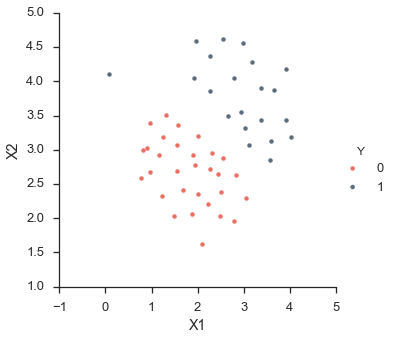

In [8]:
dataMT = sio.loadmat('ex6data1.mat')
data=pd.DataFrame(dataMT['X'],columns=['X1','X2'])
data['Y']=dataMT['y']
plotData(data)

## Step2: Implementing SVM for different values of C and visualizing the boundary

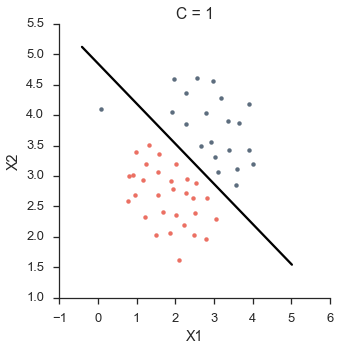

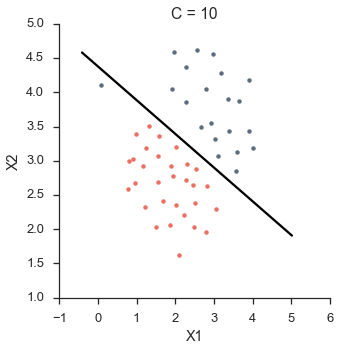

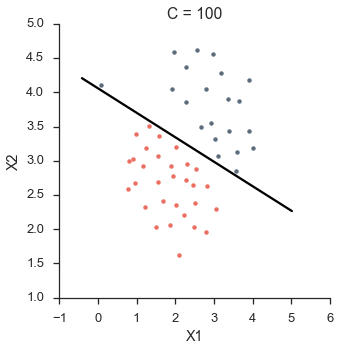

In [9]:
Cin=[1,10,100]
for c in Cin:
    clf = SVC(C=c,kernel='linear')
    clf.fit(data[['X1','X2']],data['Y'])
    data['Confidence']=clf.decision_function(data[['X1','X2']])
    theta = np.append(clf.intercept_,clf.coef_)
    VisualizeBoundary(data,theta,c)


# Second data set (SVMs  with gaussiang Kernel)

For this part we will be using SVM with gaussian kernel on the data sets which are not linearly seperable. And we will visualize the boundary for different values of C and gamma.
We will conclude that as gamma increases for constant value of C >> High Variance (Overfit)
And as C increases for constant values for gamma >> High Variance (Overfit)

In [206]:
def VisualizeBoundaryNL(data2,model,c,g):
    xv,yv = np.meshgrid(np.linspace(data2['X1'].min(),data2['X1'].max(),num=100),np.linspace(data2['X2'].min(),data2['X2'].max(),num=100))
    y = np.zeros(xv.shape)
    for i in range(xv.shape[1]):
        y[:,i]=model.predict(np.vstack((xv[:,i],yv[:,i])).T)
    plotData(data2)
    plt.contour(xv,yv,y)
    plt.title('C: %d , gamma = %d'%(c,g))

In [207]:
def GaussianKernel(x1,x2,sigma):
    return np.exp(-(np.linalg.norm(x1-x2)**2)/(2*(sigma**2)))

## Step1 : Loading and Visualizing the data

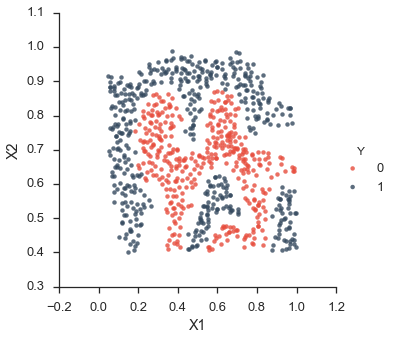

In [210]:
dataMT2 = sio.loadmat('ex6data2.mat')
data2 = pd.DataFrame(dataMT2['X'],columns=['X1','X2'])
data2['Y']=dataMT2['y']
plotData(data2)

## Step2 :  SVM with Gaussian Kernel for different values of C and gamma

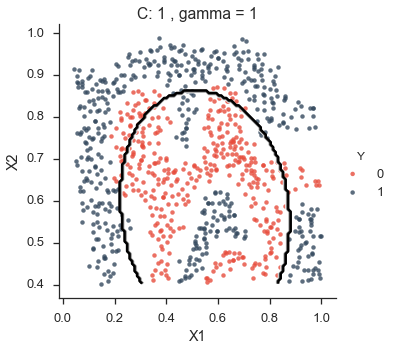

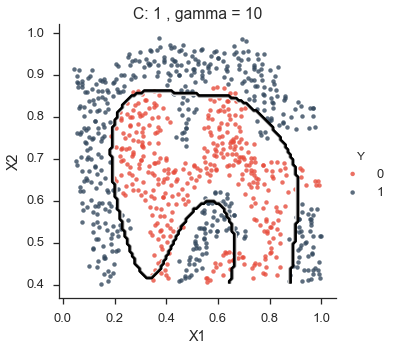

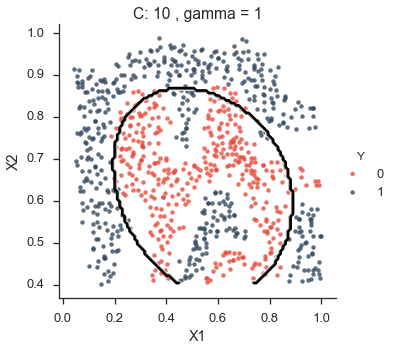

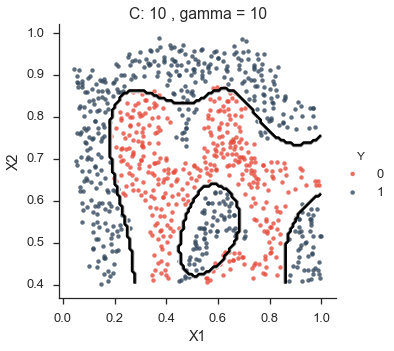

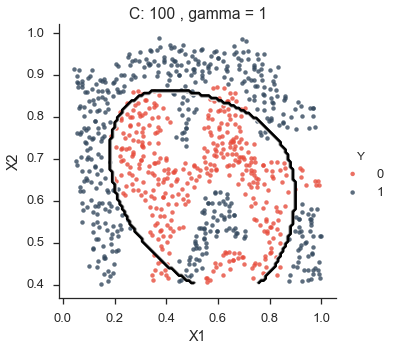

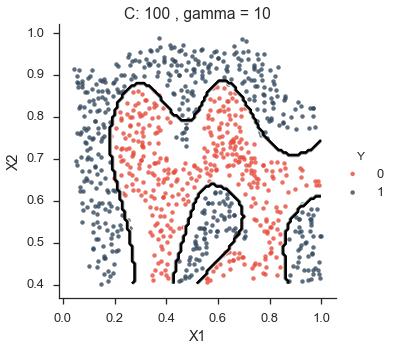

In [213]:
C=[1,10,100]
gamma = [1,10]
for c in C:
    for g in gamma: 
        clfG = SVC(C=c,gamma= g, kernel='rbf') 
        clfG.fit(data2[['X1','X2']],data2['Y'])
        VisualizeBoundaryNL(data2,clfG,c,g)


# Third Data Set

Now that we understand SVM for linear and gaussian kernel, we will implement the SVM with gaussian kernel for different values of C and gamma and choose the final C and gamma values, which gives the best score for validation data sets.

## Step1: Plotting and Visualizing the data set

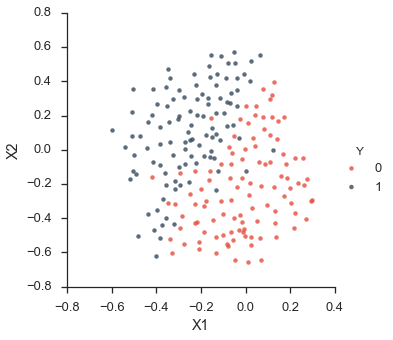

In [214]:
dataMT3 = sio.loadmat('ex6data3.mat')
data3 = pd.DataFrame(dataMT3['X'],columns=['X1','X2'])
data3['Y']=dataMT3['y']
plotData(data3)

## Step2 : SVM with gaussian kernel

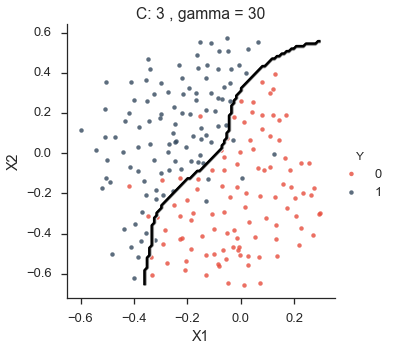

In [215]:
C=[0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]
gamma = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]
best_score = 0
best_C = 0
best_gamma = 0
for c in C:
    for g in gamma: 
        clfG = SVC(C=c,gamma= g, kernel='rbf') 
        clfG.fit(data3[['X1','X2']],data3['Y'])
        score = clfG.score(dataMT3['Xval'],dataMT3['yval'])
        if score>best_score:
            best_score = score
            best_C = c
            best_gamma = g
            
# Now that we have the values of best C and gamma, Let's Visualize the boundary:
clfG = SVC(C=best_C, gamma = best_gamma, kernel='rbf')
clfG.fit(data3[['X1','X2']],data3['Y'])
VisualizeBoundaryNL(data3,clfG,best_C, best_gamma)



# Email Spam Classification using SVM

Now that we have understood SVM, we will use our knowledge of SVM to classify an email into spam or non-spam categories.
1. We will need to convert each email into feature vector.
2. Classify email to spam or non-spam using SVM with gaussian kernel. 


## A. Preprocessing Emails

While many emails would contain similar types of entities (e.g., numbers, other URLs, or other email addresses), the specific entities (e.g., the specific URL or specific dollar amount) will be different in almost every email. Therefore, one method often employed in processing emails is to “normalize” these values, so that all URLs are treated the same, all numbers are treated the same, etc. For example, we could replace each URL in the email with the unique string “httpaddr” to indicate that a URL was present.
This has the effect of letting the spam classifier make a classification decision based on whether any URL was present, rather than whether a specific URL was present. This typically improves the performance of a spam classifier, since spammers often randomize the URLs, and thus the odds of seeing any particular URL again in a new piece of spam is very small.

In processEmail function, we have implemented the following email prepro- cessing and normalization steps:

1) Lower-casing: The entire email is converted into lower case, so that captialization is ignored (e.g., IndIcaTE is treated the same as Indicate).

2) Stripping HTML: All HTML tags are removed from the emails. Many emails often come with HTML formatting; we remove all the HTML tags, so that only the content remains.

3) Normalizing URLs: All URLs are replaced with the text “httpaddr”.

4) Normalizing Email Addresses: All email addresses are replaced with the text “emailaddr”.

5) Normalizing Numbers: All numbers are replaced with the text “number”.

6)  Normalizing Dollars: All dollar signs ($) are replaced with the text “dollar”.

7) Word Stemming: Words are reduced to their stemmed form. For ex- ample, “discount”, “discounts”, “discounted” and “discounting” are all replaced with “discount”. Sometimes, the Stemmer actually strips off additional characters from the end, so “include”, “includes”, “included”, and “including” are all replaced with “includ”.

8) Removal of non-words: Non-words and punctuation have been re- moved. All white spaces (tabs, newlines, spaces) have all been trimmed to a single space character.

After preprocessing the emails, we have a list of words for each email. The next step is to choose which words we would like to use in our classifier and which we would want to leave out.
For this exercise, we have chosen only the most frequently occuring words as our set of words considered (the vocabulary list). Since words that occur rarely in the training set are only in a few emails, they might cause the model to overfit our training set. The complete vocabulary list is in the file vocab.txt.
Given the vocabulary list, we can now map each word in the preprocessed emails into a list of word indices that contains the index of the word in the vocabulary list.

(This text is borrowed from the exercise from Andrew Ng's machine learning class on Coursera.)

In [220]:
import re,string
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

In [222]:
def ProcessEmail(emailContent):
    # Removing all html from the email
    emailContent = re.sub('<[^<>]+>','',emailContent)
    
    # Replacing  all the urls by a text httpaddr
    emailContent = re.sub('http\w?://\S+','httpaddr',emailContent)
    
    # Replacing all the email addresses with text emailaddr
    emailContent = re.sub('\S+@[a-z]+.com\s','emailaddr',emailContent)
    
    # Replacing all the numbers by text number
    emailContent = re.sub('[0-9]+','number',emailContent)
    
    # Replacing dollar sign with word dollar
    emailContent = re.sub('\$','dollar',emailContent)
    
    # Removing newline and punctuations and whitespaces from the email
    emailContent = re.sub('\n',' ',emailContent)
    emailContent = re.sub('[^(\w|\s+)]','',emailContent)
    emailContent = re.sub('\s+',' ',emailContent)
    
    # Reducing words to their stemmed form in email
    ps = PorterStemmer()
    words = word_tokenize(emailContent)
    word_indices = []
    emailContent = ''
    f = open('vocab.txt')
    vocab = []
    for line in f:
        vocab.append(re.search('[a-z]+',line).group().strip())
    vocab = pd.DataFrame(vocab,columns=['V'])
    f.close()
    for w in words:
        emailContent = emailContent+ps.stem(w)+' '
        # Mapping words in preprocessed emails into a list of word indices that contains the index...
        # of the word in the vocabulary list.
        x = vocab[vocab['V']==ps.stem(w)].index.tolist()
        if len(x)==1:
            word_indices.append(x[0]) 
    print(emailContent.strip())
   
    
    return word_indices

In [223]:
def Extractfeatures(indices):
    features=np.zeros((1899,1)).astype(int)
    features[indices,0]=1
    return features

In [224]:
f = open('emailSample1.txt')
emailContent = ''
for line in f:
    emailContent+=line.lower()
f.close()
word_indices = ProcessEmail(emailContent)
features= Extractfeatures(word_indices)

anyon know how much it cost to host a web portal well it depend on how mani visitor your expect thi can be anywher from less than number buck a month to a coupl of dollarnumb you should checkout httpaddr or perhap amazon ecnumb if your run someth big to unsubscrib yourself from thi mail list send an email to emailaddr


# Classification of Email into spam or non-spam using SVM

Now that we know how to extract features from the email. We will implement SVM with linear kernel for a given Training data sets for different values of C and choose the SVM model which gives the best accuracy for the validation (test) data set

In [226]:
# Loading the Training Data Set
spamTrain = sio.loadmat('spamTrain')
spamTraindata = pd.DataFrame(spamTrain['X'])
spamTraindata['Y']=spamTrain['y']

# Loading the test Data Set
spamTest = sio.loadmat('spamTest')
spamTestdata = pd.DataFrame(spamTest['Xtest'])
spamTestdata['Ytest']=spamTest['ytest']

# SVM model:

C=[0.1, 1, 3, 10, 30]
best_score = 0
best_C = 0
best_gamma = 0
for c in C:
    clfG = SVC(C=c,kernel='linear') 
    clfG.fit(spamTraindata.drop('Y',axis=1),spamTraindata['Y'])
    score = clfG.score(spamTestdata.drop('Ytest',axis=1),spamTestdata['Ytest'])
    if score>best_score:
        best_score = score
        best_C = c
            
# Now that we have the values of best C and gamma, Let's Visualize the boundary:
print('Best Score is %0.3f'%best_score)
clfG = SVC(C=best_C,kernel='linear')
clfG.fit(spamTraindata.drop('Y',axis=1),spamTraindata['Y'])


Best Score is 0.989


SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Conclusion:

In this project I leared to implement SVM with linear and gaussian kernel and used the knowledge to classify the email into spam or nor-spam category.
We get 98.9% accuracy for the test data set for C=0.1 for email classification